Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-------------------
Dataset caricato. Record Totali:  45012
-------------------
        Date and Time  Temperature  ...  Ozone   NO2
0 2018-04-20 00:00:00         22.5  ...   4.49  0.71
1 2018-04-20 00:01:00         22.5  ...   4.48  0.60
2 2018-04-20 00:02:00         22.5  ...   4.32  0.22
3 2018-04-20 00:03:00         22.4  ...   4.50  0.97
4 2018-04-20 00:04:00         22.5  ...   4.54  0.88

[5 rows x 10 columns]
-------------------
Scegli il campo:
1  -  Temperature
2  -  Relative Humidity
3  -  PM2.5
4  -  TVOC
5  -  CO2
6  -  CO
7  -  Air Pressure
8  -  Ozone
9  -  NO2
-------------------
Totale record:  45012
        Date and Time     CO2
0 2018-04-20 00:00:00  1085.0
1 2018-04-20 00:01:00  1112.0
2 2018-04-20 00:02:00  1106.0
3 2018-04-20 00:03:00  1100.0
4 2018-04-20 00:04:00  1106.0
-------------------
Scegli una frequenza (intervallo temporale) pe

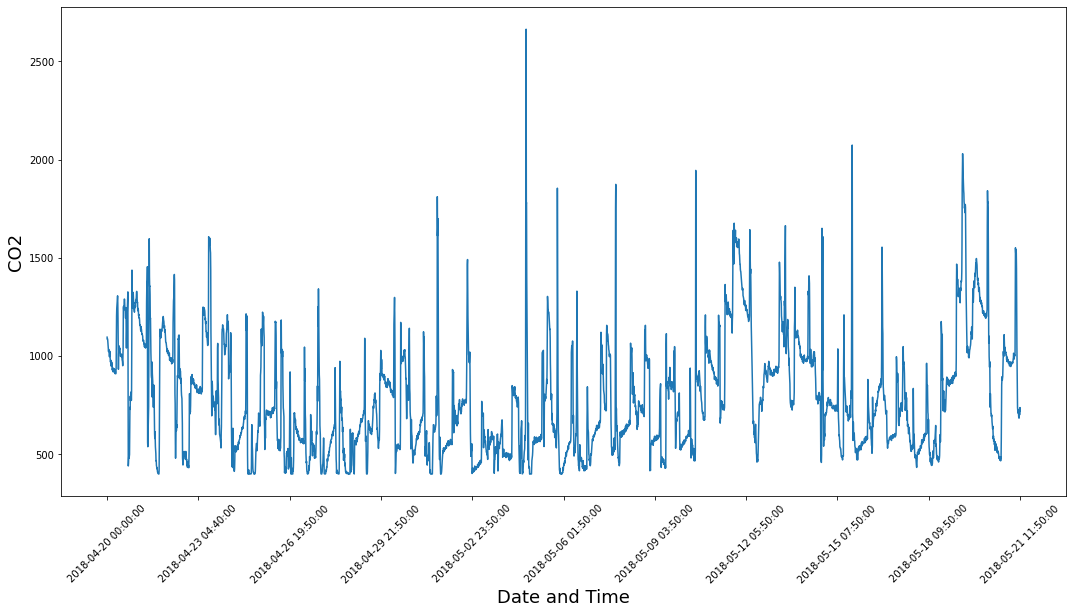

Scegliere come dividere il Dataset in train / test
Es. 0.75  => 75% train e 25% test (default = 0.88): 
--------------------------- LSTM ----------------------------

Totale record utilizzati per il training : 3909

Totale record utilizzati per il test: 533

Tempo  d'esecuzione: 3:35:40

Obs type: <class 'numpy.float64'>
yhat type: <class 'numpy.float64'>
-------------------------------------------------------------

Test RMSE: 52.71

-------------------------------------------------------------


--------------------------- ARIMA ----------------------------

Totale record utilizzati per il training : 3909

Totale record utilizzati per il test : 533

Test RMSE: 54.45

Tempo  d'esecuzione: 0:03:27

--------------------------------------------------------------



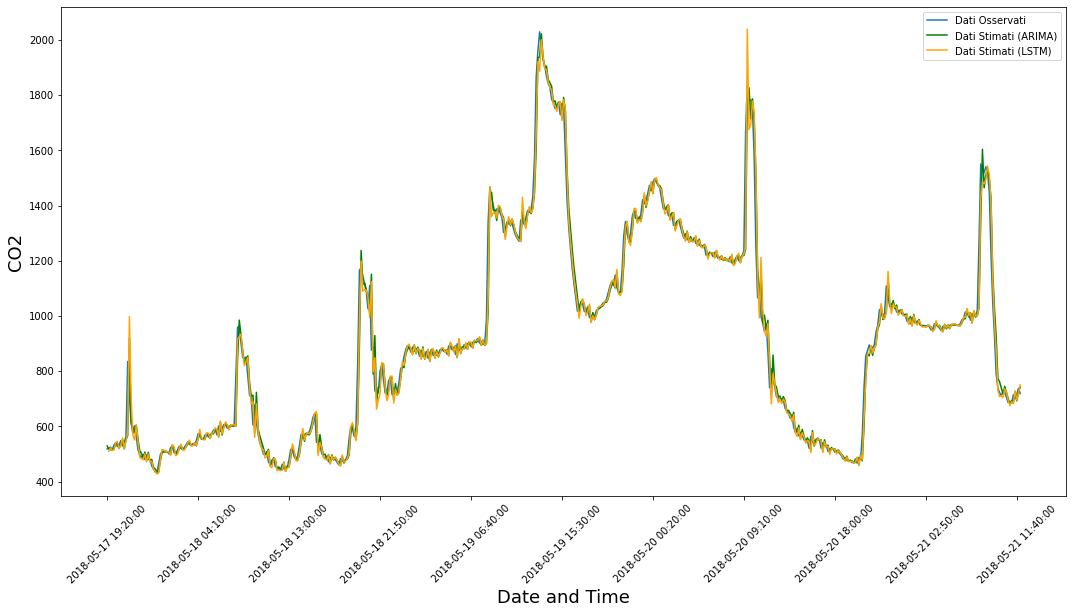

In [ ]:
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import os
import numpy
import datetime
import time
from google.colab import drive

##################### FUNZIONI PER LSTM ###############################

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

"""
Nella compilazione della rete, dobbiamo specificare una funzione di perdita e un algoritmo di ottimizzazione.
Uso " mean_squared_error " come funzione di perdita in quanto corrisponde strettamente a RMSE
e l'algoritmo di ottimizzazione ADAM (ADAptive Moment estimation=Stima del momento adattivo).
Utilizzo l'API di Keras sequenziali per definire la rete,
quindi creo la rete e la compilo
"""

# Creazione del modello LSTM
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1)) 
	model.compile(loss="mean_squared_error", optimizer="adam")
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# Passo di predizione
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
##################### FUNZIONI PER LSTM (fine) #########################

# Mount di Google drive

drive.mount("/content/drive")
dataSet="/content/drive/My Drive/Colab Notebooks/Dataset/AirQualityParameters.csv"
# Download del file al seguente indirizzo:
# https://drive.google.com/file/d/1t_Jx8JKEi8CsMeyQACFndhDAlV27rVCZ/view?usp=sharing


# Load del Dataset
parser = lambda date: pd.to_datetime(date)
series = read_csv(os.path.join(dataSet), header=0, parse_dates=[0], date_parser=parser, squeeze=True)

print ("-------------------")
print ("Dataset caricato. Record Totali: ", len(series))
print ("-------------------")
print(series.head())
print ("-------------------")

fields=["Date and Time","Temperature","Relative Humidity","PM2.5","TVOC","CO2","CO","Air Pressure","Ozone","NO2"]
print ("Scegli il campo:")
for i in range(1,len(fields)):
	print (i," - ",fields[i])
sceltaCampo=input("Scelta (default = 5 - CO2): \n")

if (sceltaCampo==""):
	sceltaCampo=5
else:
	sceltaCampo=int(sceltaCampo)
 
#Elimino dalla serie le altre colonne
for i in range(1,len(fields)):
	if (i>0 and i!=sceltaCampo):
		series.drop(fields[i],axis=1,inplace=True)

print ("-------------------")
print("Totale record: ", len(series))
print(series.head())
print ("-------------------")


# Imposto una frequenza per il calcolo della media

print("Scegli una frequenza (intervallo temporale) per il calcolo della media")
print ("1 - 1 Ora")
print ("2 - 45 Minuti")
print ("3 - 30 Minuti")
print ("4 - 20 Minuti")
print ("5 - 10 Minuti")

sceltaFreq=input("Scelta (default = 1 - 1 Ora): \n")

if sceltaFreq=="1":
	valFreq="1H"
elif sceltaFreq=="2":
	valFreq="45min"
elif sceltaFreq=="3":
	valFreq="30min"
elif sceltaFreq=="4":
	valFreq="20min"
elif sceltaFreq=="5":
	valFreq="10min"
else:
	valFreq="1H"

# Serve per attribuire i ticks corretti alla scala delle x nei report
datesForTicks=series

# Raggruppo per data e calcolo la media con la frequenza scelta
series=series.groupby([pd.Grouper(key=fields[0], freq=valFreq)]).mean()
#Elimino eventuali NaN dovuti a "buchi" temporali nella serie...
series=series.dropna()

print ("-------------------")
print("Totale record: ", len(series))
print ("-------------------")
series=series.reset_index()

#Disegno il grafico 
ticks=int(round(len(series)/10))
pyplot.figure(figsize = (18,9))
pyplot.plot(range(series.shape[0]),series[fields[sceltaCampo]])
pyplot.xticks(range(0,series.shape[0],ticks),series[fields[0]].loc[::ticks],rotation=45)
pyplot.xlabel(fields[0],fontsize=18)
pyplot.ylabel(fields[sceltaCampo],fontsize=18)
pyplot.show()


print("Scegliere come dividere il Dataset in train / test")
print("Es. 0.75  => 75% train e 25% test (default = 0.88): ")
sceltaSplit=input("Scelta: ")

if (sceltaSplit==""):
	split=0.88
else:
	split=float(sceltaSplit)	

# Generazione file dei risultati
resultPath="/content/drive/My Drive/Colab Notebooks/Dataset/Result_MediaFreq=" + str(valFreq) + "_Split=" + str(split) + ".txt"
resultFile=open(resultPath,"w")

############## LSTM ##########################

# Trasformazione dei dati in "Stazionari"
# Rimuovo la tendenza "differenziando" i dati:
# Dato dell'osservazione corrente (t) - dato dell'osservazione precedente (t-1)
# Questo elimina la tendenza: rimane una serie di differenze da un passaggio temporale all'altro.

raw_values = series.loc[:,fields[sceltaCampo]].values
diff_values = difference(raw_values,1)

# Shift di 1 della serie
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# divido la serie in 2: serie di training e serie di test
numTrain=int(round(len(series)*split))
numTest=len(series)-numTrain

train, test = supervised_values[:numTrain], supervised_values[numTrain:numTrain+numTest]

# Serve per attribuire i ticks corretti alla scala delle x nei report
dateTimeTestSeries=series.iloc[numTrain:numTrain+numTest,0]
dateTimeTestList=dateTimeTestSeries.tolist()

inizioLSTM=time.perf_counter()

# transformo la scala [-1, 1]
scaler, train_scaled, test_scaled = scale(train, test)

# Imposto il modello
# La funzione predict () sul modello è vincolata alla dimensione del batch
# il batcht_size e' impostato su 1 perché siamo interessati a fare previsioni one-step sui dati del test.

batchSize=1
nbEpoch=3000
neurons=4

lstm_model = fit_lstm(train_scaled, batchSize, nbEpoch, neurons)

# calcolo i dati stimati sull'intera serie di training
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# Calcolo del tempo impiegato
elapsedLSTM=str(datetime.timedelta(seconds=int(time.perf_counter()-inizioLSTM)))

# Stampa dei risultati
line1="--------------------------- LSTM ----------------------------\n"
line2="Totale record utilizzati per il training : " + str(numTrain) + "\n"
line3="Totale record utilizzati per il test: " + str(numTest) + "\n"
line4="Tempo  d'esecuzione: " + str(elapsedLSTM) + "\n"
# Stampa a video
print(line1)
print(line2)
print(line3)
print(line4)
# Stampa su file
resultFile.write(line1)
resultFile.write(line2)
resultFile.write(line3)
resultFile.write(line4)


predictionsLSTM = list()
for i in range(len(test_scaled)):
	# Eseguo la predizione one-step
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# Inverto la scala
	yhat = invert_scale(scaler, X, yhat)
	# Inverto la differenza
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# Registro la predizione
	predictionsLSTM.append(yhat)
	obs = raw_values[len(train) + i + 1]
	line= "Date & Time = " + str(dateTimeTestList[i]) + ", Osservato = " + str(round(obs,2)) + " , Stimato = " + str(round(yhat,2)) + "\n"
	resultFile.write(line)

# Misurazione della performance in RMSE
# radice dell'errore quadratico medio
# indica la discrepanza quadratica media fra i valori dei 
# dati osservati ed i valori dei dati stimati.

rmseLSTM = sqrt(mean_squared_error(raw_values[-len(test):], predictionsLSTM))
line5="-------------------------------------------------------------\n"
line6="Test RMSE: " + str(round(rmseLSTM,2)) + "\n"
# Stampa a video
print(line5)
print(line6)
print(line5)
# Stampa su file
resultFile.write(line5)
resultFile.write(line6)
resultFile.write(line5)

############################### ARIMA ###############################

inizioARIMA=time.perf_counter() 
series.set_index(fields[0],inplace=True)

X = series.values
size = int(round(len(X) * split))

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictionsARIMA = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictionsARIMA.append(yhat)
	obs = test[t]
	history.append(obs)	
	line=fields[0] + " = " + str(dateTimeTestList[t]) + ", Osservato = " + str(round(obs[0],2)) + " , Stimato = " + str(round(yhat[0],2)) + "\n"
	resultFile.write(line)

rmseARIMA = sqrt(mean_squared_error(test, predictionsARIMA))

# Stampa dei risultati
line7 = "\n--------------------------- ARIMA ----------------------------\n"
line8 = "Totale record utilizzati per il training : " + str(len(train)) + "\n"
line9 = "Totale record utilizzati per il test : " + str(len(test)) + "\n"
line10 = "Test RMSE: " + str(round(rmseARIMA,2)) + "\n"
# Stampa a video
print(line7)
print(line8)
print(line9)
print(line10)
# Stampa su file
resultFile.write(line7)
resultFile.write(line8)
resultFile.write(line9)
resultFile.write(line10)

elapsedARIMA=str(datetime.timedelta(seconds=int(time.perf_counter()-inizioARIMA)))

line11 = "Tempo  d'esecuzione: " + str(elapsedARIMA) + "\n"
line12 = "--------------------------------------------------------------\n"
# Stampa a video
print(line11)
print(line12)
# Stampa su file
resultFile.write(line11)
resultFile.write(line12)
resultFile.close()

# Ripristino un record vuoto tolto queando e' stato effettuato lo Shift di 1 della serie
predictionsLSTM.insert(0, None)

# Grafico di confronto: dati osservati - predizione LSTM - predizione ARIMA
ticks=int(round(len(dateTimeTestSeries)/10))
pyplot.figure(figsize = (18,9))
pyplot.xticks(range(0,len(dateTimeTestSeries),ticks),dateTimeTestSeries.loc[::ticks],rotation=45)
pyplot.xlabel(fields[0],fontsize=18)
pyplot.ylabel(fields[sceltaCampo],fontsize=18)
pyplot.plot(raw_values[-len(test):],label="Dati Osservati")
pyplot.plot(predictionsARIMA, color="green",label="Dati Stimati (ARIMA)")
pyplot.plot(predictionsLSTM, color="orange",label="Dati Stimati (LSTM)")
pyplot.legend()
pyplot.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
